In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pylab import rcParams
import seaborn as sb
import scipy
from scipy.stats.stats import pearsonr

### Preprocesamiento de datos

Disponemos de dos bases de datos reales de pacientes, las cuales proporcionan información de los diagnósticos de estos y de su **LOS** ( _Length of Stay_ ) en el hospital, pese a que esto último no está explícito.

In [0]:
diagnose_df = pd.read_excel("Tablas exportadas\Datos_diagnosticos.xlsx") # Datos de diagnostico de pacientes
process_df = pd.read_excel("Tablas exportadas\Datos_procedimientos.xlsx") # Datos de procedimientos de pacientes

Podemos ver los datos y sus tipos en ambas bases de datos.

In [0]:
diagnose_df.head()

,CASE,Seq,PrincSec,Diagnosis
0,13872110,1,P,E6601
1,13872110,1,S,Z6841
2,13872110,1,S,DDDDDD
3,14035188,1,P,J984
4,14035188,1,S,I119


In [0]:
process_df = process_df.rename({"Case": "CASE"}, axis="columns")

process_df.head()

,CASE,Procedure,Date,Release
0,13872110,0DB64Z3,2018-01-18,2018-01-21
1,14035188,0BB64ZZ,2018-01-11,2018-01-14
2,14085514,0QP934Z,2018-02-07,2018-02-08
3,14111667,0DB64Z3,2018-04-09,2018-04-12
4,14111831,0DB64Z3,2018-01-08,2018-01-10


#### Filtro de datos

_<< Aquí debemos aplicar filtros a las bases de datos por si contienen datos erróneos, incompletos, repetidos, etc >>_

### Análisis de datos

Dado que queremos predecir tiempos de estadía en los hospitales, agregamos una nueva columna **LOS** a ```process_df```. 

In [0]:
# Se calcula el LOS (en dias) para cada fila de la base de datos de procedimientos
LOS_columns = [(obs[1]["Release"] - obs[1]["Date"]).days for obs in process_df.iterrows()]

In [0]:
# Se inserta una nueva columna a la 'process_df' con los datos de LOS
process_df.insert(4, "LOS (days)", LOS_columns, allow_duplicates=True)

In [0]:
process_df.head()

,CASE,Procedure,Date,Release,LOS (days)
0,13872110,0DB64Z3,2018-01-18,2018-01-21,3
1,14035188,0BB64ZZ,2018-01-11,2018-01-14,3
2,14085514,0QP934Z,2018-02-07,2018-02-08,1
3,14111667,0DB64Z3,2018-04-09,2018-04-12,3
4,14111831,0DB64Z3,2018-01-08,2018-01-10,2


Ahora, ordenamos los datos de ```process_df``` en base a su LOS.

In [0]:
sorted_process_df = process_df.sort_values(by=["LOS (days)"])

sorted_process_df.head()

,CASE,Procedure,Date,Release,LOS (days)
26567,15057706,10D28ZZ,2018-06-30,2018-06-30,0
23236,14949108,5A2204Z,2018-05-25,2018-05-25,0
23263,14949529,0PSJXZZ,2018-05-20,2018-05-20,0
23264,14949529,0PSLXZZ,2018-05-20,2018-05-20,0
17047,14808746,3E03305,2018-04-04,2018-04-04,0


Procedemos a graficar los datos en histograma para ver cómo distribuye el **LOS** de los datos.

In [0]:
# Esto es opcional; se establece un filtro en la base de datos para mapear aquellos que 
# tengan un LOS menor o igual a cierta cantidad de días
corte_LOS = 25
sorted_process_df_filtered = sorted_process_df[sorted_process_df["LOS (days)"] <= corte_LOS]

Cantidad de datos con un LOS <= 25: 24058 filas.
Se han graficado un 90.55 % de los datos.


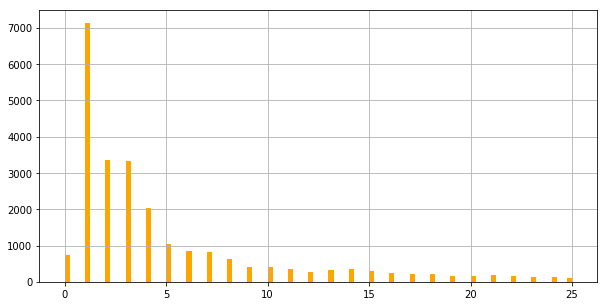

In [0]:
filtered_length = len(sorted_process_df_filtered) # Tamaño de la base de datos filtrada
plotted_perc = round(100 * (filtered_length / len(sorted_process_df)), 2) # Se calcula el porcentaje filtrado

print(f"Cantidad de datos con un LOS <= {corte_LOS}: {filtered_length} filas.")
print(f"Se han graficado un {plotted_perc} % de los datos.")

# Se mapean los datos en el histograma
hist = sorted_process_df_filtered["LOS (days)"].hist(bins=100, figsize=(10, 5), color="orange")

Dado el gráfico anterior, se puede ver que la gran mayoría de los datos oscila entre valores de 0 y 20. Esto quiere decir que la mayoría de los pacientes (sobre el 80 %) está entre 0 y 20 días hospitalizado en la clínica.

Ahora en la base de datos de diagnóstico, clasificaremos estos por su primera letra, para poder establecer un análisis más adecuado.

In [0]:
diagnose_df.head()

,CASE,Seq,PrincSec,Diagnosis
0,13872110,1,P,E6601
1,13872110,1,S,Z6841
2,13872110,1,S,DDDDDD
3,14035188,1,P,J984
4,14035188,1,S,I119


Hacemos un join de ambas tablas.

In [0]:
joined = pd.merge(sorted_process_df, diagnose_df, on="CASE")
joined.drop_duplicates(keep=False, inplace=True)

joined.head()

,CASE,Procedure,Date,Release,LOS (days),Seq,PrincSec,Diagnosis
0,15057706,10D28ZZ,2018-06-30,2018-06-30,0,1,P,O0010
1,15057706,10D28ZZ,2018-06-30,2018-06-30,0,2,P,O0010
2,15057706,10D28ZZ,2018-06-30,2018-06-30,0,2,S,Z3A00
3,15057706,10D28ZZ,2018-06-30,2018-06-30,0,2,S,DDDDDD
4,14949108,5A2204Z,2018-05-25,2018-05-25,0,1,P,UUUUUU


Dividiremos la base de datos por _P_ o _S_ según el tipo de atención **PrincSec**.

In [0]:
joined_P = joined[joined["PrincSec"] == "P"].reset_index()

joined_P.head()

,index,CASE,Procedure,Date,Release,LOS (days),Seq,PrincSec,Diagnosis
0,0,15057706,10D28ZZ,2018-06-30,2018-06-30,0,1,P,O0010
1,1,15057706,10D28ZZ,2018-06-30,2018-06-30,0,2,P,O0010
2,4,14949108,5A2204Z,2018-05-25,2018-05-25,0,1,P,UUUUUU
3,5,14949108,5A2204Z,2018-05-25,2018-05-25,0,2,P,J189
4,16,14949108,5A12012,2018-05-25,2018-05-25,0,1,P,UUUUUU


In [0]:
joined_S = joined[joined["PrincSec"] == "S"].reset_index()

joined_S.head()

,index,CASE,Procedure,Date,Release,LOS (days),Seq,PrincSec,Diagnosis
0,2,15057706,10D28ZZ,2018-06-30,2018-06-30,0,2,S,Z3A00
1,3,15057706,10D28ZZ,2018-06-30,2018-06-30,0,2,S,DDDDDD
2,6,14949108,5A2204Z,2018-05-25,2018-05-25,0,2,S,G7111
3,7,14949108,5A2204Z,2018-05-25,2018-05-25,0,2,S,E46
4,8,14949108,5A2204Z,2018-05-25,2018-05-25,0,2,S,Z681


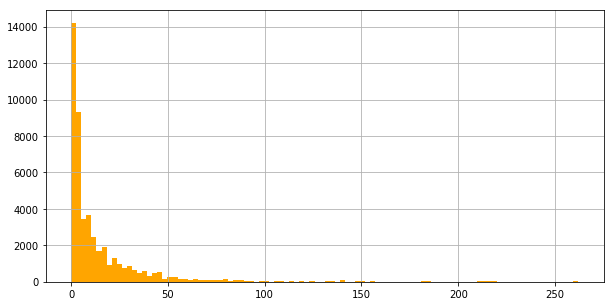

In [0]:
hist = joined_P["LOS (days)"].hist(bins=100, figsize=(10, 5), color="orange")

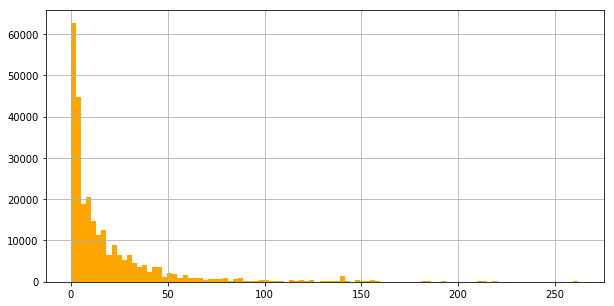

In [0]:
hist = joined_S["LOS (days)"].hist(bins=100, figsize=(10, 5), color="orange")

Vemos que distribuyen de manera parecida tanto _S_ como _P_ para **PrincSec**. Ahora graficaremos en base al tipo de diagnóstico que se ha realizado. Estos diagnósticos se clasificarán según las letras del abecedario.

Creamos una nueva tabla que tenga datos del tipo de diagnóstico (A, B, C, ...., Y, Z) y sus LOS.

In [0]:
# Guardamos el diagnostico de acuerdo a su primera letra
diagnose_class = [d[0] for d in joined["Diagnosis"]]

# Creamos una tabla con Diagnosticos, LOS y PrincSec
diagnose_LOS = {"Diagnosis": diagnose_class, 
                "LOS (days)": list(joined["LOS (days)"]), 
                "PrincSec": list(joined["PrincSec"])}

diagnose_LOS = pd.DataFrame(diagnose_LOS)

diagnose_LOS

,Diagnosis,LOS (days),PrincSec
0,O,0,P
1,O,0,P
2,Z,0,S
3,D,0,S
4,U,0,P
5,J,0,P
6,G,0,S
7,E,0,S
8,Z,0,S
9,J,0,S


## Análisis Diagnóstico

Filtramos la tabla anterior para PrincSec "P" o "S".

In [0]:
diagnose_LOS_P = diagnose_LOS[diagnose_LOS["PrincSec"] == "P"].reset_index()
diagnose_LOS_S = diagnose_LOS[diagnose_LOS["PrincSec"] == "S"].reset_index()

In [0]:
diagnose_LOS_P.head()

,index,Diagnosis,LOS (days),PrincSec
0,0,O,0,P
1,1,O,0,P
2,4,U,0,P
3,5,J,0,P
4,16,U,0,P


In [0]:
diagnose_LOS_S.head()

,index,Diagnosis,LOS (days),PrincSec
0,2,Z,0,S
1,3,D,0,S
2,6,G,0,S
3,7,E,0,S
4,8,Z,0,S


Ahora generamos una tabla que para cada tipo de diagnostico, entrega un dato del LOS y su frecuencia.

In [0]:
grouped_by_los = diagnose_LOS.groupby(['Diagnosis', 'LOS (days)'], as_index=False).size()

grouped_by_los = pd.DataFrame(grouped_by_los).reset_index().rename(columns={0: "Frequency"})

sum(grouped_by_los["Frequency"]) # Esto verifica que los datos han sido bien agrupados

312145

In [0]:
grouped_by_los

,Diagnosis,LOS (days),Frequency
0,A,0,53
1,A,1,85
2,A,2,54
3,A,3,71
4,A,4,68
5,A,5,62
6,A,6,59
7,A,7,72
8,A,8,73
9,A,9,75


TypeError: xlabel() missing 1 required positional argument: 's'

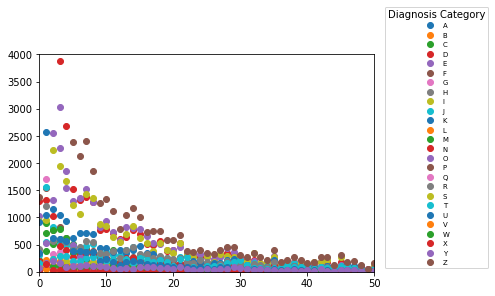

In [0]:
lista = list(grouped_by_los["Diagnosis"].unique())
# Se grafican los diferentes LOS de acuerdo al diagnostico

for i in range(len(lista)):
    
    filtro = grouped_by_los[grouped_by_los["Diagnosis"] == lista[i]].reset_index()

    # Se recorre el dataframe para el tipo de diagnostico
    plt.plot(filtro["LOS (days)"], filtro["Frequency"], marker="o", label=f"{lista[i]}", linestyle="None")

plt.legend(numpoints=1, loc='best', bbox_to_anchor=(0.5, 0., 0.85, 0.5), 
           fontsize="x-small", title="Diagnosis Category")

plt.ylim(0, 4000) # Esto define los limites visuales del eje y
plt.xlim(0, 50) # Lo mismo para el eje x

plt.xlabel(xlabel="LOS")
plt.ylabel(ylabel="Frequency")

plt.show()

Ahora, creamos una función para exportar las tablas a archivos csv.

In [0]:
def export_to_csv(df, name):
    df.to_csv(f'{name}.csv', index=False, header=True)

In [0]:
# Exportamos la tabla del join de ambas bases de datos
export_to_csv(joined, "joined_databases_by_CASE.csv")

# Exportamos la tabla anterior, filtrada por PrincSec 'P' o 'S'
export_to_csv(joined_P, "filtered_joined_P.csv")
export_to_csv(joined_S, "filtered_joined_S.csv")

# Exportamos la tabla de diagnosticos clasificados por su primera letra, junto al LOS y PrincSec
export_to_csv(diagnose_LOS, "classified_diagnosis_table.csv")

# Exportamos la misma tabla anterior, pero filtrada por PrincSec
export_to_csv(diagnose_LOS_P, "classified_diagnosis_P.csv")
export_to_csv(diagnose_LOS_S, "classified_diagnosis_S.csv")

# Exportamos la tabla agrupada de los tipos de diagnosticos, con el LOS y su frecuencia para cada tipo.
export_to_csv(grouped_by_los, "diagnose_table_grouped_by_los.csv")



Realizamos un boxplot para ver la media y la distribución del periodo de días de un paciente P, para cada diagnosis

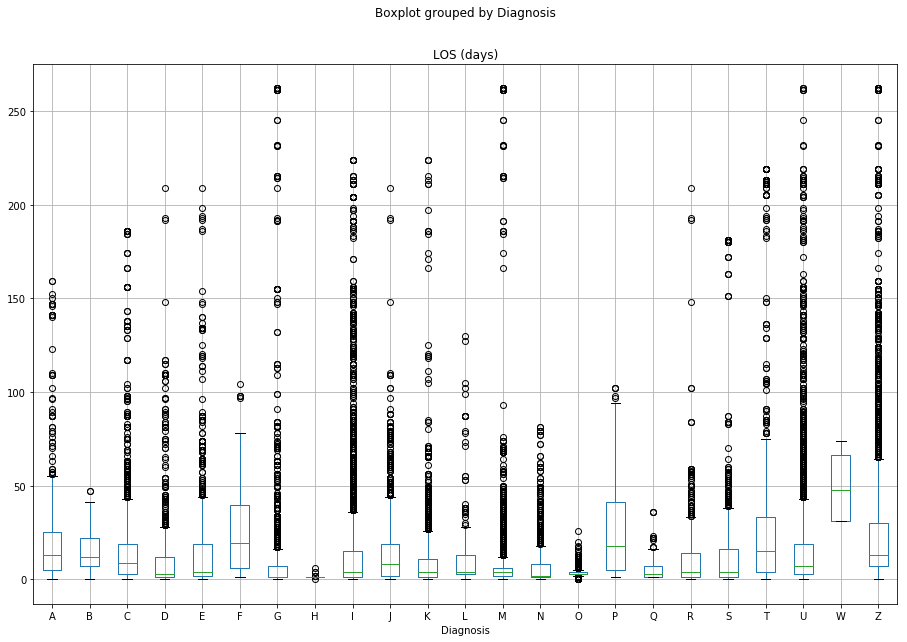

In [0]:
diagnose_LOS_P.boxplot(column= 'LOS (days)', by = 'Diagnosis', figsize = (15,10))
plt.show()

Realizamos un box plot para ver la media y desviación para el caso S. 

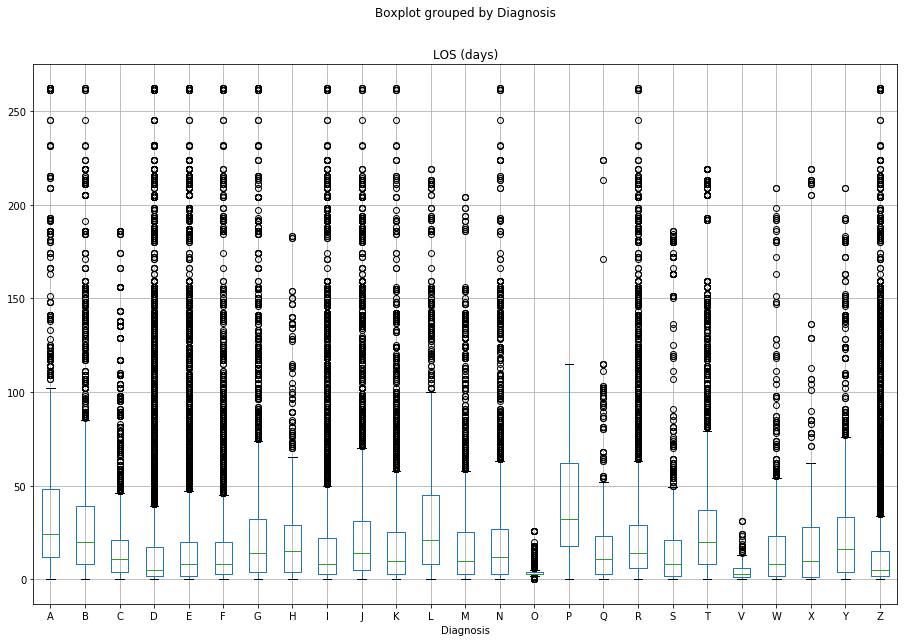

In [0]:
diagnose_LOS_S.boxplot(column= 'LOS (days)', by = 'Diagnosis', figsize = (15,10))
plt.show()

Podemos ver que para la secuencia secundaria, la cantidad de días que estan los pacientes por cada diagnóstico tienen una gran desviación en comparación con una secuencia primaria. Esto es relevante para estudiar correctamente posibles outliers del data.

## Análisis Procedimientos

In [0]:
procedure_LOS_P = procedure_LOS[procedure_LOS["PrincSec"] == "P"].reset_index()
procedure_LOS_S = procedure_LOS[procedure_LOS["PrincSec"] == "S"].reset_index()

In [66]:
grouped2_by_los = procedure_LOS.groupby(['Procedure', 'LOS (days)'], as_index=False).size()

grouped2_by_los = pd.DataFrame(grouped2_by_los).reset_index().rename(columns={0: "Frequency"})

sum(grouped2_by_los["Frequency"]) # Esto verifica que los datos han sido bien agrupados

312145

TypeError: xlabel() missing 1 required positional argument: 's'

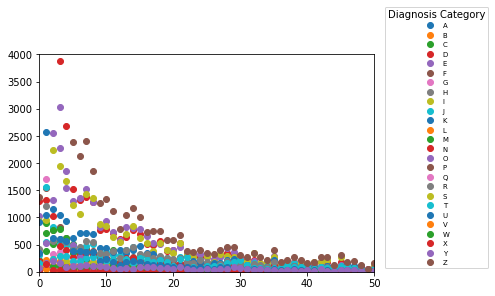

In [0]:
lista = list(grouped2_by_los["Diagnosis"].unique())
# Se grafican los diferentes LOS de acuerdo al diagnostico

for i in range(len(lista)):
    
    filtro = grouped2_by_los[grouped2_by_los["Procedure"] == lista[i]].reset_index()

    # Se recorre el dataframe para el tipo de diagnostico
    plt.plot(filtro["LOS (days)"], filtro["Frequency"], marker="o", label=f"{lista[i]}", linestyle="None")

plt.legend(numpoints=1, loc='best', bbox_to_anchor=(0.5, 0., 0.85, 0.5), 
           fontsize="x-small", title="Procedure Category")

plt.ylim(0, 4000) # Esto define los limites visuales del eje y
plt.xlim(0, 50) # Lo mismo para el eje x

plt.xlabel(xlabel="LOS")
plt.ylabel(ylabel="Frequency")

plt.show()

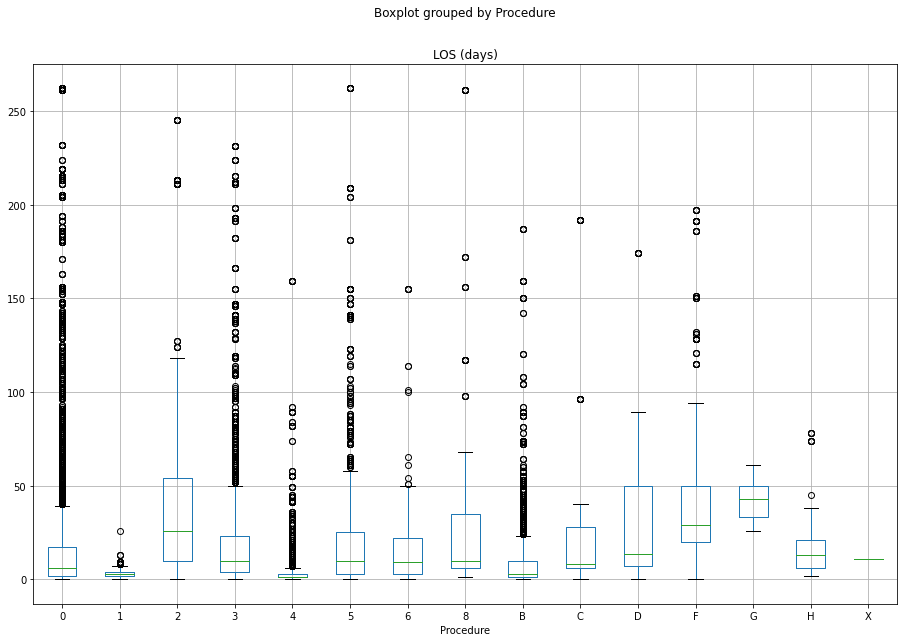

In [67]:
procedure_LOS_P.boxplot(column= 'LOS (days)', by = 'Procedure', figsize = (15,10))
plt.show()

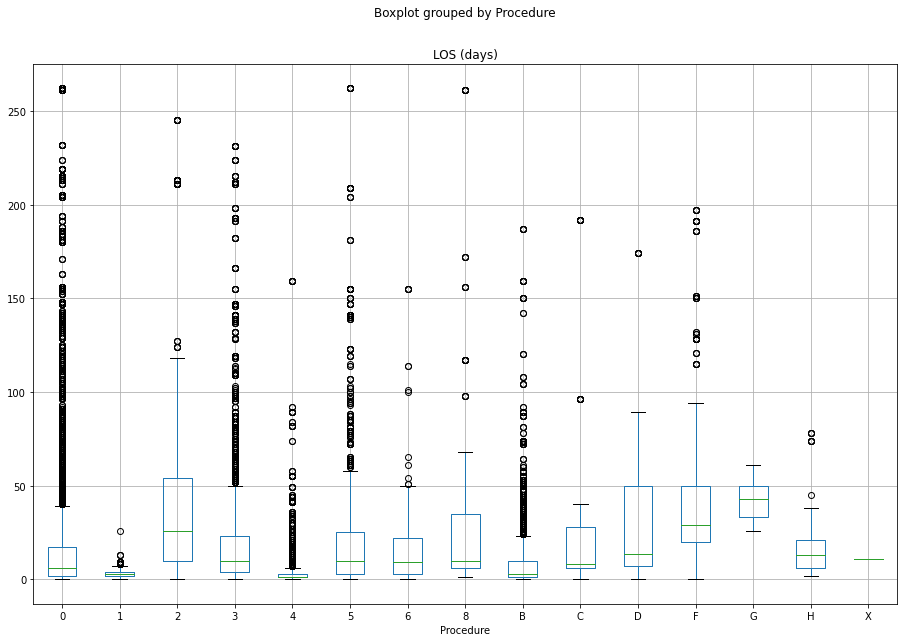

In [68]:
procedure_LOS_P.boxplot(column= 'LOS (days)', by = 'Procedure', figsize = (15,10))
plt.show()

## Veamos los procedimientos

In [0]:
joined.head()

In [0]:
# Guardamos los procedimientos de acuerdo a su categoria principal
columna_procedimiento_generico = [procedimiento[0] for procedimiento in joined["Procedure"]]


db_datos = joined[['LOS (days)', 'Seq', 'PrincSec']]
#db_datos.assign(diagnose_class=diagnose_class)
#db_datos.assign(columna_procedimiento_generico=columna_procedimiento_generico)


db_datos['Procedure'] = pd.Series(columna_procedimiento_generico)
db_datos['Diagnosis'] = pd.Series(diagnose_class)

db_datos.head()

c:\users\marti\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
c:\users\marti\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


,LOS (days),Seq,PrincSec,Procedure,Diagnosis
0,0,1,P,1,O
1,0,2,P,1,O
2,0,2,S,1,Z
3,0,2,S,1,D
4,0,1,P,5,U


In [0]:
# manejamos los setings de nuestra visualizacion
%matplotlib inline
rcParams['figure.figsize'] = 5, 4
sb.set_style('whitegrid')

In [0]:
#nota: solo plotea las dos numericas
sb.pairplot(db_datos)

#separamos cada columna numerica
los = db_datos['LOS (days)']
seq = db_datos['Seq']
    
# imprimamos su correlacion
correlacion, _ =pearsonr(los, seq)
print(f'Correlacion los y seq : {correlacion}')
    

## Sacaremos los LOS mayores a 10

In [0]:
db_datos_recortada = db_datos[db_datos["LOS (days)"] <= 10]
db_datos_p = db_datos_recortada[db_datos_recortada['PrincSec'] == "P"]
db_datos_s = db_datos_recortada[db_datos_recortada['PrincSec'] == "S"]

### Separaremos en 4 grupos, 2 para cada db

In [0]:
db_datos_p_1_parte = db_datos_p[
    (db_datos_p['Procedure'] == "0") | 
    (db_datos_p['Procedure'] == "1") |
    (db_datos_p['Procedure'] == "2") |
    (db_datos_p['Procedure'] == "3") |
    (db_datos_p['Procedure'] == "4") |
    (db_datos_p['Procedure'] == "5") |
    (db_datos_p['Procedure'] == "6") |
    (db_datos_p['Procedure'] == "7") 
]

db_datos_p_2_parte = db_datos_p[
    (db_datos_p['Procedure'] == "8") |
    (db_datos_p['Procedure'] == "9") |
    (db_datos_p['Procedure'] == "B") |
    (db_datos_p['Procedure'] == "D") |
    (db_datos_p['Procedure'] == "F") |
    (db_datos_p['Procedure'] == "G") |
    (db_datos_p['Procedure'] == "H") |
    (db_datos_p['Procedure'] == "X") 
]

db_datos_s_1_parte = db_datos_s[
    (db_datos_s['Procedure'] == "0") |
    (db_datos_s['Procedure'] == "1") |
    (db_datos_s['Procedure'] == "2") |
    (db_datos_s['Procedure'] == "3") |
    (db_datos_s['Procedure'] == "4") |
    (db_datos_s['Procedure'] == "5") |
    (db_datos_s['Procedure'] == "6") |
    (db_datos_s['Procedure'] == "7") 
]

db_datos_s_2_parte = db_datos_s[
    (db_datos_s['Procedure'] == "8") |
    (db_datos_s['Procedure'] == "9") |
    (db_datos_s['Procedure'] == "B") |
    (db_datos_s['Procedure'] == "D") |
    (db_datos_s['Procedure'] == "F") |
    (db_datos_s['Procedure'] == "G") |
    (db_datos_s['Procedure'] == "H") |
    (db_datos_s['Procedure'] == "X") 
]



### Veamos los heat maps

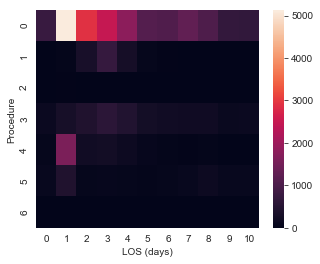

In [0]:
# heat map de procedimientos
sb.heatmap(pd.crosstab(db_datos_p_1_parte["Procedure"], db_datos_p_1_parte["LOS (days)"]))

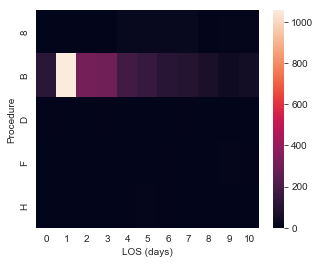

In [0]:
sb.heatmap(pd.crosstab(db_datos_p_2_parte["Procedure"], db_datos_p_2_parte["LOS (days)"]))

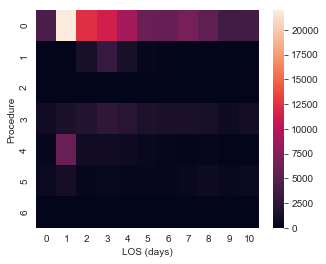

In [0]:
sb.heatmap(pd.crosstab(db_datos_s_1_parte["Procedure"], db_datos_s_1_parte["LOS (days)"]))

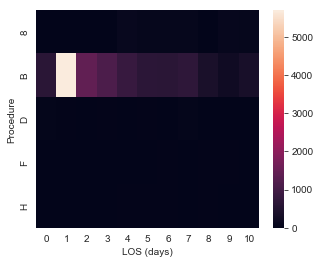

In [0]:
sb.heatmap(pd.crosstab(db_datos_s_2_parte["Procedure"], db_datos_s_2_parte["LOS (days)"]))

In [0]:
# Crearemos 17 db para cada procedimiento
db_0 = db_datos_p[db_datos_p['Procedure'] == "0"]
db_1 = db_datos_p[db_datos_p['Procedure'] == "1"]
db_2 = db_datos_p[db_datos_p['Procedure'] == "2"]
db_3 = db_datos_p[db_datos_p['Procedure'] == "3"]
db_4 = db_datos_p[db_datos_p['Procedure'] == "4"]
db_5 = db_datos_p[db_datos_p['Procedure'] == "5"]
db_6 = db_datos_p[db_datos_p['Procedure'] == "6"]
db_7 = db_datos_p[db_datos_p['Procedure'] == "7"]
db_8 = db_datos_p[db_datos_p['Procedure'] == "8"]
db_9 = db_datos_p[db_datos_p['Procedure'] == "9"]
db_B = db_datos_p[db_datos_p['Procedure'] == "B"]
db_C = db_datos_p[db_datos_p['Procedure'] == "C"]
db_D = db_datos_p[db_datos_p['Procedure'] == "D"]
db_F = db_datos_p[db_datos_p['Procedure'] == "F"]
db_G = db_datos_p[db_datos_p['Procedure'] == "G"]
db_H = db_datos_p[db_datos_p['Procedure'] == "H"]
db_X = db_datos_p[db_datos_p['Procedure'] == "X"]

databases_1_parte = []
databases_1_parte.append(db_0)
databases_1_parte.append(db_1)
databases_1_parte.append(db_2)
databases_1_parte.append(db_3)
databases_1_parte.append(db_4)
databases_1_parte.append(db_5)
databases_1_parte.append(db_6)
databases_1_parte.append(db_7)

databases_1_2_parte = []
databases_1_2_parte.append(db_8)
databases_1_2_parte.append(db_9)
databases_1_2_parte.append(db_B)
databases_1_2_parte.append(db_C)
databases_1_2_parte.append(db_D)
databases_1_2_parte.append(db_F)
databases_1_2_parte.append(db_G)
databases_1_2_parte.append(db_H)
databases_1_2_parte.append(db_X)


## Evaluar caso a caso para ver cada procedimiento por separado

ojo aqui, nos indica problemas con los datos! hay problemas en especifico la db 7

In [0]:

for db_procedimiento in databases_1_parte:
    
    # seleccionamos algunas variables
    seleccion_db_datos = db_procedimiento[['LOS (days)', 'Seq']]
    
    # Descomentar si quieres graficar
    #sb.pairplot(seleccion_db_datos)

    #separamos cada columna
    los = seleccion_db_datos['LOS (days)']
    seq = seleccion_db_datos['Seq']
    
    # imprimamos su correlacion
    correlacion, _ =pearsonr(los, seq)
    print(f'Correlacion los y seq : {correlacion}')

    
for db_procedimiento in databases_2_parte:
    
    # seleccionamos algunas variables
    seleccion_db_datos = db_procedimiento[['LOS (days)', 'Seq']]
    
    # Descomentar si quieres graficar
    #sb.pairplot(seleccion_db_datos)

    #separamos cada columna
    los = seleccion_db_datos['LOS (days)']
    seq = seleccion_db_datos['Seq']
    
    # imprimamos su correlacion
    correlacion, _ =pearsonr(los, seq)
    print(f'Correlacion los y seq : {correlacion}')
    

Correlacion los y seq : 0.3211016901356445
Correlacion los y seq : 0.16378665538589673
Correlacion los y seq : 0.4916306108193197
Correlacion los y seq : 0.266669332941116
Correlacion los y seq : 0.4301289510859703
Correlacion los y seq : 0.23900564106563424
Correlacion los y seq : -0.13129610256228127


ValueError: x and y must have length at least 2.

Veamos los promedios segun procedimiento y segun diagnostico

In [0]:
for i in range(17):
    aux = i
    if(aux == 10):
        aux = "B"
    elif(aux == 11):
        aux = "C"
    elif(aux == 12):
        aux = "D"
    elif(aux == 13):
        aux = "F"
    elif(aux == 14):
        aux = "G"
    elif(aux == 15):
        aux = "H"
    elif(aux == 16):
        aux = "X"
    aux = str(aux)
    
    promedio = databases[i]["LOS (days)"].mean()
        
    print(f'El promedio de LOS del procedimiento {aux} es: {promedio}')

El promedio de LOS del procedimiento 0 es: 14.979234678423586
El promedio de LOS del procedimiento 1 es: 3.1745009658725047
El promedio de LOS del procedimiento 2 es: 57.00837988826816
El promedio de LOS del procedimiento 3 es: 19.57767871883771
El promedio de LOS del procedimiento 4 es: 4.746817538896747
El promedio de LOS del procedimiento 5 es: 20.483211678832117
El promedio de LOS del procedimiento 6 es: 19.706214689265536
El promedio de LOS del procedimiento 7 es: nan
El promedio de LOS del procedimiento 8 es: 33.41004184100419
El promedio de LOS del procedimiento 9 es: nan
El promedio de LOS del procedimiento B es: 10.029007177033494
El promedio de LOS del procedimiento C es: 30.14423076923077
El promedio de LOS del procedimiento D es: 36.166666666666664
El promedio de LOS del procedimiento F es: 48.18803418803419
El promedio de LOS del procedimiento G es: 43.0
El promedio de LOS del procedimiento H es: 19.04950495049505
El promedio de LOS del procedimiento X es: 11.0


## Hagamos un heatmat pero con LOS hasta 10

In [0]:
db_datos_recortada = db_datos_p[db_datos_p["LOS (days)"] <= 10]

In [0]:
db_datos_recortada.head()

,LOS (days),Seq,PrincSec,Procedure,Diagnosis
0,0,1,P,1,O
1,0,2,P,1,O
4,0,1,P,5,U
5,0,2,P,5,J
16,0,1,P,5,U


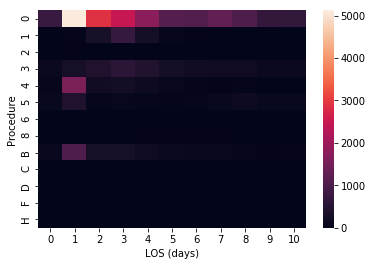

In [0]:
# heat map de procedimientos
sb.heatmap(pd.crosstab(db_datos_recortada["Procedure"], db_datos_recortada["LOS (days)"]))

In [0]:
sb.heatmap(pd.crosstab(db_datos_recortada["Diagnosis"], db_datos_recortada["LOS (days)"]))

# Saquemos las correlaciones
nota: esto factoriza segun orden, para sacar correlaciones numericas

In [0]:
db_datos_recortada.apply(lambda x: x.factorize()[0]).corr()

 # Sacaremos el procedimiento 0 que se despega mucho

In [0]:
db_datos_recortada_sin_0 = db_datos_recortada[db_datos_recortada["Procedure"] != "0"]

In [0]:
# heat map de procedimientos sin mas comun
sb.heatmap(pd.crosstab(db_datos_recortada_sin_0["Procedure"], db_datos_recortada_sin_0["LOS (days)"]))

In [0]:
sb.heatmap(pd.crosstab(db_datos_recortada_sin_algunos["Diagnosis"], db_datos_recortada_sin_algunos["LOS (days)"]))